In [2]:
from __future__ import print_function, division
from nilmtk import DataSet
from os.path import join
from pylab import rcParams
import nilmtk as nilmtk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


dataset = DataSet("../../data/iawe/iawe.h5")
dataset.set_window(start="7-13-2013", end="9-4-2013")

In [3]:
dataset.metadata

{'meter_devices': {'current_cost': {'max_sample_period': 300,
   'measurements': [{'type': 'active',
     'upper_limit': 5000,
     'lower_limit': 0,
     'physical_quantity': 'power'}],
   'description': None,
   'sample_period': 6},
  'EM6400': {'max_sample_period': 300,
   'description': 'Multifunction meter for feeders',
   'manufacturer_url': 'http://www.schneider-electric.com/',
   'model': 'EM6400',
   'measurements': [{'type': 'active',
     'upper_limit': 10000,
     'lower_limit': 0,
     'physical_quantity': 'power'},
    {'type': 'apparent',
     'upper_limit': 10000,
     'lower_limit': 0,
     'physical_quantity': 'power'},
    {'type': 'reactive',
     'upper_limit': 10000,
     'lower_limit': 0,
     'physical_quantity': 'power'},
    {'type': 'apparent',
     'upper_limit': 70,
     'lower_limit': 0,
     'physical_quantity': 'frequency'},
    {'type': 'apparent',
     'upper_limit': 270,
     'lower_limit': 0,
     'physical_quantity': 'voltage'},
    {'type': None,
 

In [4]:
dataset.buildings[1]

Building(instance=1, dataset='iAWE')

In [6]:
idx = 1
print(f"[+] Working on building: {idx}")
building_elec = dataset.buildings[idx].elec
print("[-] Main meters:")
for meter in building_elec.mains().meters:
    print(f"Main meter: {meter}, columns: {meter.available_columns()}")
print()
print("[-] Application meters:")
for meter in building_elec.meters:
    if(isinstance(meter, nilmtk.elecmeter.ElecMeter)):
        print(f"Meter: {meter}, columns: {meter.available_columns()}")
        df =  next(meter.load())
        print(df.head())
    elif(isinstance(meter, nilmtk.metergroup.MeterGroup)):
        for submeter in meter.meters:
            print(f"Sub meter: {submeter}, columns: {submeter.available_columns()}")
            df = next(submeter.load())
            print(df.head())
print()

[+] Working on building: 1
[-] Main meters:
Main meter: ElecMeter(instance=1, building=1, dataset='iAWE', site_meter, appliances=[]), columns: [('power', 'active'), ('power', 'reactive'), ('power factor', None), ('voltage', 'apparent'), ('power', 'apparent'), ('current', None), ('frequency', 'apparent')]
Main meter: ElecMeter(instance=2, building=1, dataset='iAWE', site_meter, appliances=[]), columns: [('power', 'active'), ('power', 'reactive'), ('power factor', None), ('voltage', 'apparent'), ('power', 'apparent'), ('current', None), ('frequency', 'apparent')]

[-] Application meters:
Meter: ElecMeter(instance=1, building=1, dataset='iAWE', site_meter, appliances=[]), columns: [('power', 'active'), ('power', 'reactive'), ('power factor', None), ('voltage', 'apparent'), ('power', 'apparent'), ('current', None), ('frequency', 'apparent')]
physical_quantity              power                            current
type                          active      reactive   apparent          
2013-0

In [12]:
for meter in building_elec.mains().meters:
    print(f"Main meter: {meter}, columns: {meter.available_columns()}")
    df = next(meter.load())
    print(df.columns)

Main meter: ElecMeter(instance=1, building=1, dataset='iAWE', site_meter, appliances=[]), columns: [('power', 'active'), ('power', 'reactive'), ('power factor', None), ('voltage', 'apparent'), ('power', 'apparent'), ('current', None), ('frequency', 'apparent')]
MultiIndex([(  'power',   'active'),
            (  'power', 'reactive'),
            (  'power', 'apparent'),
            ('current',         '')],
           names=['physical_quantity', 'type'])
Main meter: ElecMeter(instance=2, building=1, dataset='iAWE', site_meter, appliances=[]), columns: [('power', 'active'), ('power', 'reactive'), ('power factor', None), ('voltage', 'apparent'), ('power', 'apparent'), ('current', None), ('frequency', 'apparent')]
MultiIndex([(  'power',   'active'),
            (  'power', 'reactive'),
            (  'power', 'apparent'),
            ('current',         '')],
           names=['physical_quantity', 'type'])


# Selected devices
- Just pre-processed all devices
- Only appliances

In [360]:
def transfer_to_my_df(appliance_label, input_df: pd.DataFrame) -> pd.DataFrame:
    if(len(input_df) > 30):
        input_df = input_df[30:]
        new_df = pd.DataFrame()
        new_df["Time"] = input_df.index
        new_df["Irms"] = input_df[('current', '')].values
        new_df["Urms"] = input_df[('voltage', '')].values
        new_df["P"] = input_df[('power', 'active')].values
        new_df["Q"] = input_df[('power', 'reactive')].values
        new_df["S"] = input_df[('power', 'apparent')].values
        #New columns
        new_df["Label"] = [appliance_label]*len(input_df)
        event_array = np.zeros(len(input_df))
        event_array[0] = 1
        event_array[len(input_df)-1] = 2
        new_df["Event"] = event_array
        return new_df
    else:
        return None

def extract_turn_on_sequence(sequence_idx, appliance_activated_data: pd.DataFrame) -> pd.DataFrame:
    # Assuming your DataFrame is named 'appliance_activated_data'
    # Filter rows with Event value 1
    start_indices = appliance_activated_data[appliance_activated_data['Event'] == 1].index

    # Filter rows with Event value 2
    end_indices = appliance_activated_data[appliance_activated_data['Event'] == 2].index
    if ((sequence_idx > len(start_indices)) or (sequence_idx < 0)):
        raise ValueError(f"Sequence idx should be between 0 and {len(start_indices)}")
    
    # Get the first sequence (from start to end)
    if len(start_indices) > 0 and len(end_indices) > 0:
        first_sequence = appliance_activated_data.loc[start_indices[sequence_idx]:end_indices[sequence_idx]]
        return first_sequence
    else:
        print("No valid sequences found.")
        return pd.DataFrame
    
def plot_data(input_df, which_plot: dict):
    plt.figure(figsize=(10, 6))
    if(which_plot["Irms"] == True):
        plt.plot(input_df['Time'], input_df['Irms'], label='RMS Current (I)')
    if(which_plot["Urms"] == True):
        plt.plot(input_df['Time'], input_df['Urms'], label='RMS Voltage (V)')
    if(which_plot["P"] == True):
        plt.plot(input_df['Time'], input_df['P'], label='Power (P)')
    if(which_plot["Q"] == True):
        plt.plot(input_df['Time'], input_df['Q'], label='Reactive Power (Q)')
    if(which_plot["S"] == True):
        plt.plot(input_df['Time'], input_df['S'], label='Apparent Power (S)')
    plt.xlabel('Time')
    plt.yticks(range(0, 2000, 50))  # Set y-axis ticks at 0, 50, 100, ..., 700
    plt.title(f'{which_plot["name"]}')
    plt.legend()
    plt.grid(True)
    plt.show()

## Testing with fridge data

In [380]:
appliance_activated_dict = {}
for device_idx in [3, 8, 11]:
    appliance_label = []
    appliance_activated_data = None
    print(f"[+] Device index: {device_idx}")
    device_elec = dataset.buildings[idx].elec[device_idx]
    meters_total_df = next(device_elec.load())
    
    for appliance in device_elec.appliances:
        appliance_label.append(appliance.label(pretty=True))
    appliance_string = ','.join([str(elem) for elem in appliance_label])
        
    #Get activations
    activate_dfs = device_elec.get_activations()
    for activate_df in activate_dfs:
        full_features_activated_df = meters_total_df[meters_total_df.index.isin(activate_df.index)]
        # print(f"Len of activate df: {len(activate_df)}, Len of full feature df: {len(full_features_activated_df)}")
        if(appliance_activated_data is None):
            appliance_activated_data = transfer_to_my_df(input_df=full_features_activated_df, appliance_label=appliance_label)
        else:
            transform_data = transfer_to_my_df(input_df=full_features_activated_df, appliance_label=appliance_label)
            if(transform_data is not None):
                if not (transform_data.loc[0]):
                    appliance_activated_data = pd.concat([appliance_activated_data, transform_data])
    appliance_activated_data = appliance_activated_data.reset_index()
    appliance_activated_dict[appliance_string] = appliance_activated_data

[+] Device index: 3
[+] Device index: 8
[+] Device index: 11


In [381]:
appliance_activated_dict.keys()

dict_keys(['Fridge', 'Clothes iron', 'Wet appliance'])

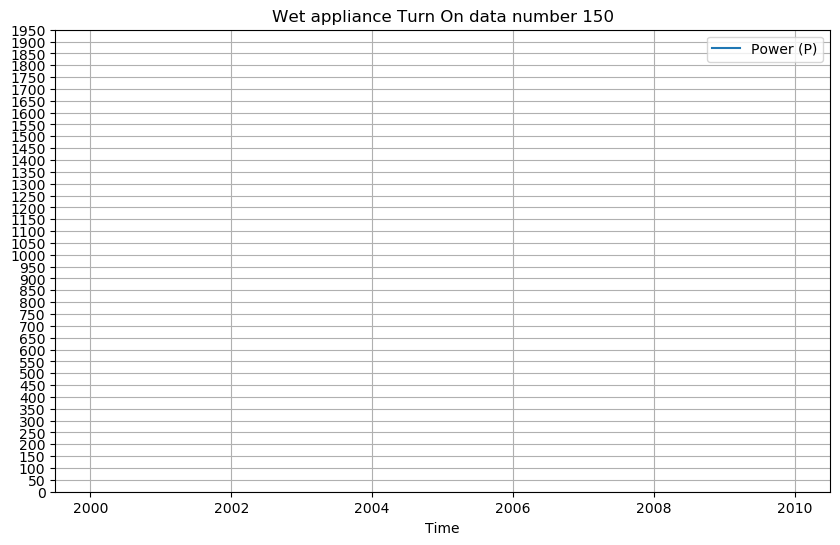

In [388]:
sequence_idx = 120
device_name = "Wet appliance"
test_sequence = extract_turn_on_sequence(appliance_activated_data=appliance_activated_dict[device_name], sequence_idx=sequence_idx)
plot_data(test_sequence, which_plot={
    "name": f"{device_name} Turn On data number {sequence_idx}",
    "Irms": False,
    "Urms": False,
    "P": True,
    "Q": False,
    "S": False
})

# Working on other data

- ElecMeter(instance=1, building=1, dataset='iAWE', site_meter, appliances=[])
- ElecMeter(instance=2, building=1, dataset='iAWE', site_meter, appliances=[])
- ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])
- ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])
- ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])
- ElecMeter(instance=7, building=1, dataset='iAWE', appliances=[Appliance(type='computer', instance=1)])
- ElecMeter(instance=9, building=1, dataset='iAWE', appliances=[Appliance(type='unknown', instance=1)])
- ElecMeter(instance=10, building=1, dataset='iAWE', appliances=[Appliance(type='television', instance=1)])
- ElecMeter(instance=12, building=1, dataset='iAWE', appliances=[Appliance(type='motor', instance=1)])

ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])
3001


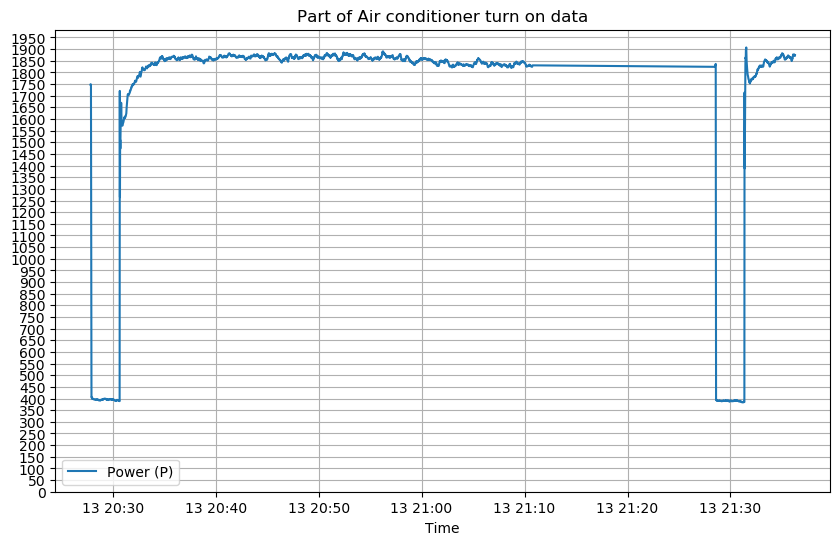

In [306]:
#4, 5, 6
building_elec = dataset.buildings[1].elec[4]
building_elec.label()
appliance_label = []

for appliance in building_elec.appliances:
    appliance_label.append(building_elec.label(pretty=True))
appliance_string = ','.join([str(elem) for elem in appliance_label])

print(building_elec)
data_df = transfer_to_my_df(input_df=next(building_elec.load()), appliance_label=appliance_string) 
test_data = data_df.loc[:3000]
# test_data = data_df

print(len(test_data))
plot_data(input_df=test_data, which_plot={
    "name": f"Part of {appliance_string} turn on data",
    "Irms": False,
    "Urms": False,
    "P": True,
    "Q": False,
    "S": False
})

In [302]:
len(test_data)

10937